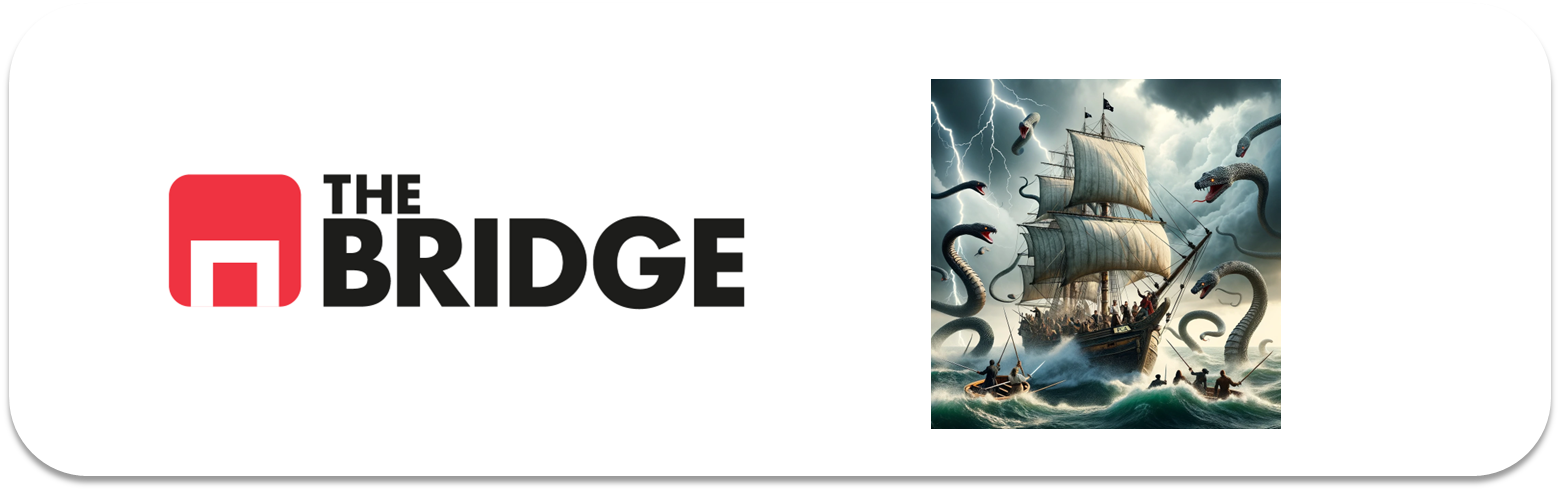

## PRACTICA OBLIGATORIA: **No Supervisado: PCA**

* La práctica obligatoria de esta unidad consiste en aplicar PCA a un dataset de imágenes con diferentes objetivos y compromisos. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### El problema de negocio

El Caesar Palace de las Vegas está planificando la instalación de mil quininetas microcámaras en los accesos a sus instalaciones para las próximas sesiones del "Poker World Championship". Estas microcámaras tienen la peculiaridad de que son capaces de tomar fotos encuadradas de las caras y la desventaja de que no tienen un gran ancho de banda de comunicación. (Las había de más ancho y de mayor precio...). NOTA: El ancho de banda limita el tamaño de las imágenes que pueden enviar las microcámaras).

El objetivo de las microcámaras es el de detectar personas "non-gratas" en tiempo real, pudiendo posprocesar las imágenes para poder detectar si han accedido a las instalaciones personas que estuvieran perseguidas por la ley, en los bancos de datos de los casinos identificadas como "peligrosas" (no se sabe si para el resto de personas o para los beneficios de los casinos) y en las listas de no admisión de jugadores adictos. Por eso no necesitan procesar los datos en tiempo real, pero sí enviarlos a un repositorio central. 

¿Cuál es su problema? O bien comprimen las imágenes y las procesan comprimidas en cada microcámara (pueden comprimir muy rápido pero no tienen cpu para procesarlas sin comprimir) o bien las comprimen y las mandan a un servidor central muy rápido (por eso ti) donde se descomprimirían y se analizarían. Analizar quiere decir en este contexto, pasarles un modelo de clasificación que determine si la persona de la imagen es una de las listas prohibidas (o sea que clasifique la imágen).  

Nos han enviado un dataset y con él debemos estudiar cuál de las dos soluciones es más interesante y dar recomendaciones al respecto. Vamos a ello.

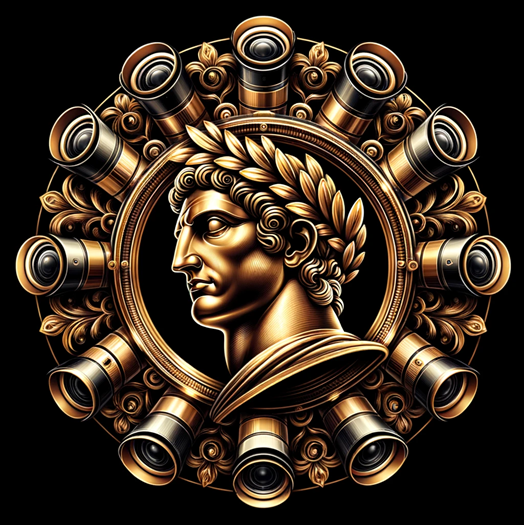

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import recall_score, make_scorer

### #1 MODELO DE BASE

**Objetivo:** Construir un modelo baseline de clasficación de imágenes que las trate sin comprimir (es decir usando todos sus píxeles).

Para conseguir el objetivo, primero descarga el dataset de las caras de Olivetti que ya has utilizado anteriormente, empleando las funciones de sklearn necesarias. Luego, construye un clasificador con el modelo que consideres más apropiado y todas las features del dataset. Eso sí, recuerda hacer lo siguiente:

1. Construir un data frame con los datos 
2. Hacer un split en train y test con al menos 80 instancias en el test y estratificado según el target. Este split se ha de mantener en el resto de la práctica
3. Hacer un quick miniEDA o justificar el no hacerlo.
4. Medir la recall media (“balanced_accuracy”) sobre cross validation con 5 folds y sobre el conjunto de test y guarda ambas para usarlas como baseline en las siguientes partes




In [210]:
#Importamos los datos
from sklearn.datasets import fetch_olivetti_faces

In [211]:
caras = fetch_olivetti_faces(shuffle=True, random_state=42)
print(caras["DESCR"])

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for some side movement).

**Data Set Characteristics:**

=================   =====================
Classes              

In [212]:
#Definimos feautres y targets
X=caras.data
y= caras.target
#Creamos DF
df=pd.DataFrame(X)
df["label"]=y

In [213]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,label
0,0.198347,0.235537,0.351240,0.409091,0.421488,0.429752,0.500000,0.528926,0.524793,0.553719,...,0.508264,0.524793,0.504132,0.483471,0.471074,0.285124,0.061983,0.128099,0.090909,20
1,0.185950,0.128099,0.115702,0.132231,0.185950,0.268595,0.433884,0.541322,0.570248,0.586777,...,0.396694,0.409091,0.301653,0.421488,0.462810,0.247934,0.190083,0.210744,0.210744,28
2,0.508264,0.603306,0.619835,0.628099,0.657025,0.665289,0.690083,0.727273,0.743802,0.768595,...,0.301653,0.305785,0.314050,0.326446,0.338843,0.330579,0.334711,0.342975,0.342975,3
3,0.136364,0.140496,0.185950,0.280992,0.318182,0.363636,0.409091,0.417355,0.438017,0.454545,...,0.169421,0.206612,0.276859,0.355372,0.685950,0.661157,0.280992,0.371901,0.276859,21
4,0.652893,0.644628,0.652893,0.706612,0.714876,0.719008,0.743802,0.747934,0.747934,0.756198,...,0.074380,0.074380,0.082645,0.082645,0.111570,0.070248,0.086777,0.185950,0.231405,9


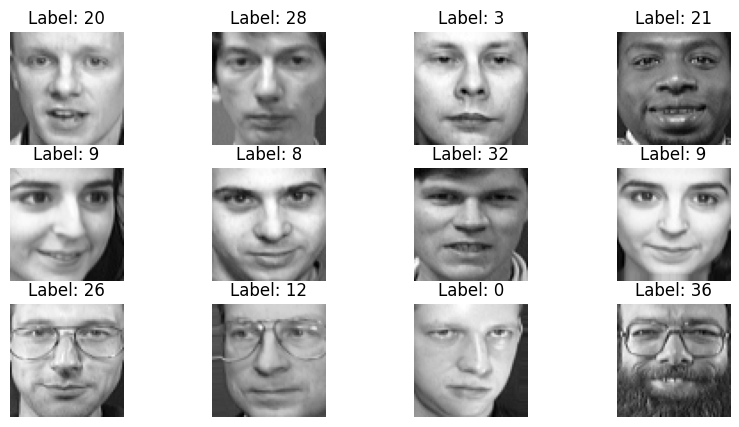

In [214]:
#Veamos una muestra
fig, axes = plt.subplots(3, 4, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(64, 64), cmap='gray')
    ax.set_title(f'Label: {y[i]}')
    ax.axis('off')
plt.show()

In [215]:
#Escalamos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns=['label']))

In [216]:
#Dividimos el DF en Train(80%)-Test(20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [217]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(320, 4096)
(320,)
(80, 4096)
(80,)


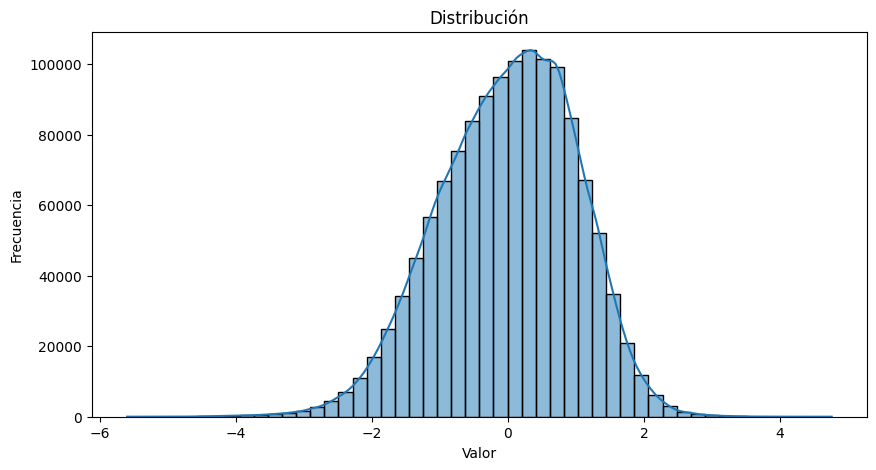

In [218]:
#Veamos la distribución de los pixels

plt.figure(figsize=(10, 5))
sns.histplot(X_train.flatten(), bins=50, kde=True)
plt.title("Distribución")
plt.xlabel("Valor")
plt.ylabel("Frecuencia")
plt.show()

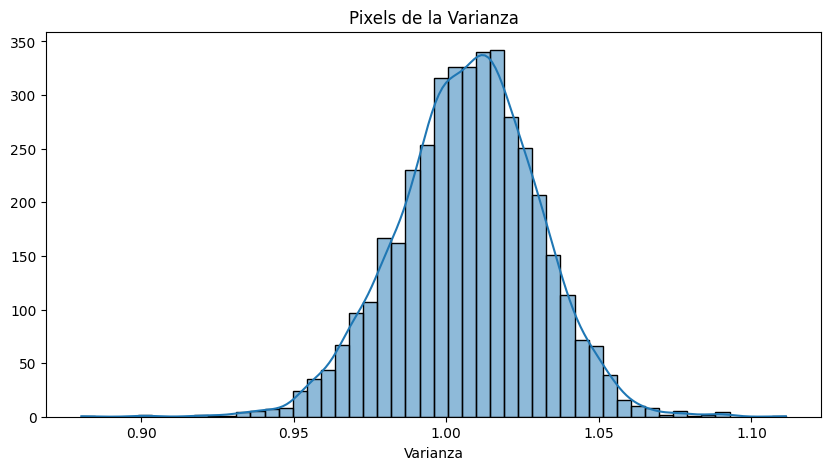

In [219]:
#Mini EDA
pixel_variance = np.var(X_train, axis=0)
plt.figure(figsize=(10, 5))
sns.histplot(pixel_variance, bins=50, kde=True)
plt.title("Pixels de la Varianza")
plt.xlabel("Varianza")
plt.ylabel("")
plt.show()


In [220]:
#Creamos el rf
rf= RandomForestClassifier(max_depth=7,random_state=42)
rf_cross_scores=cross_val_score(rf,X_train,y_train,scoring="balanced_accuracy",cv=5)
rf_mean_score= rf_cross_scores.mean()
rf_mean_score

0.7949999999999999

In [221]:
rf.fit(X_train,y_train)
rf_test_predict= rf.predict(X_test)
rf_test_score=balanced_accuracy_score(y_test,rf_test_predict)
print(rf_test_score)

0.8125


### #2 MODELO PARA LAS MICROCÁMARAS
**Objetivo:** Construir un modelo que pueda funcionar en las microcámaras, es decir que pueda funcionar con datos comprimidos.

Para cumplir con el objetivo se os ocurre emplear la doble propiedad de la PCA, que permite comprimir datos y mantener la capacidad informativa de estos. Sigue los siguientes pasos:
1. Instancia un objeto PCA sobre los datos de Train sin especificar ni componentes ni varianza explicada (o sea sin pasar argumentos).
2. Escoge un rango de valores para el número de PCAs que permitan por lo menos una compresión de la imagen de entre el 0.2% y el 2.5% (prueba al menos 5 valores). NOTA: La compresión es la reducción total, es decir una reducción del 1% quiere decir que el dataset se reduce a un 1% de su tamaño original)
3. Para el rango anterior entrena un modelo de clasificación y apunta su scoring en una validación cruzada de 5 folds y métrica el recall medio y su scoring contra test.
4. Muestra en un dataframe el valor de numero de componentes principales empleado, el scoring en CV, el scoring contra test, el % de compresión, la diferencia con el scoring de CV del modelo base, la diferencia con el scoring en test.
5. Escoge el número de componentes que permitirían tener la mayor compresión con una pérdida inferior a 3 puntos porcentuales tanto en CV como en test. Si no hay escoge el que tenga una pérdida inferior a 5 puntos porcentuales. 

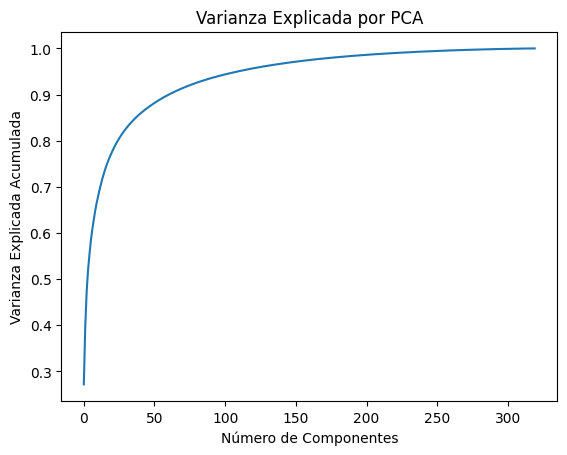

In [222]:
# Instanciar PCA
pca = PCA(random_state=42)
pca.fit(X_train)

# Explorar la varianza explicada
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Graficar la varianza explicada acumulada
plt.plot(cumulative_variance)
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada por PCA')
plt.show()

In [223]:
modelo_pca=PCA()
X_train_transformed=modelo_pca.fit_transform(X_train)
X_test_transformed=modelo_pca.transform(X_test)

In [224]:
# Como debemos estar en un rango de 0.2% y 2.5% probaremos 5 valores de n_components
components_range = [9, 20, 25, 35, 102] # ya que 9 sería el mínimo (0.2%) y 102 el máximo (2.5%)
results = []

In [225]:
# Modelo base (sin PCA) para comparar
base_model = RandomForestClassifier(random_state=42)
cv_base_score = np.mean(cross_val_score(base_model, X_train, y_train, cv=5, scoring=make_scorer(recall_score, average='macro')))
base_model.fit(X_train, y_train)
test_base_score = recall_score(y_test, base_model.predict(X_test), average='macro')


In [226]:

for n_components in components_range:
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Entrenar modelo
    model = RandomForestClassifier(random_state=42)
    cv_score = np.mean(cross_val_score(model, X_train_pca, y_train, cv=5, scoring=make_scorer(recall_score, average='macro')))
    model.fit(X_train_pca, y_train)
    test_score = recall_score(y_test, model.predict(X_test_pca), average='macro')

    # Calcular compresión y diferencias de rendimiento
    compression = 100 * (1 - n_components / X.shape[1])
    diff_cv = cv_score - cv_base_score
    diff_test = test_score - test_base_score

    results.append([n_components, cv_score, test_score, compression, diff_cv, diff_test])

# Crear DataFrame con los resultados
df_results = pd.DataFrame(results, columns=["N_Components", "CV_Score", "Test_Score", "Compression_%", "Diff_CV", "Diff_Test"])

# Seleccionar mejor número de componentes según criterios
best_df = df_results[(df_results["Diff_CV"] > -0.03) & (df_results["Diff_Test"] > -0.03)]
if best_df.empty:
    best_df = df_results[(df_results["Diff_CV"] > -0.05) & (df_results["Diff_Test"] > -0.05)]

best_components = best_df.sort_values("Compression_%", ascending=False).iloc[0]["N_Components"] if not best_df.empty else None

df_results, best_components

(   N_Components  CV_Score  Test_Score  Compression_%  Diff_CV  Diff_Test
 0             9    0.8025      0.8625      99.780273  -0.1325    -0.0875
 1            20    0.8950      0.9250      99.511719  -0.0400    -0.0250
 2            25    0.9275      0.9125      99.389648  -0.0075    -0.0375
 3            35    0.9150      0.9625      99.145508  -0.0200     0.0125
 4           102    0.8600      0.9500      97.509766  -0.0750     0.0000,
 35.0)

In [227]:
#Me quedo con 35 componentes, que consigue con solo un 99% de los datos originales mejorar los scores en cv y en test.


### #3 COMPRESION PARA CLASIFICACION POSTERIOR

**Objetivo**: Obtener el número de componentes que permita una compresión menor y al tiempo que el modelo en el servidor central no baje su rendimiento respecto a no usar imágenes comprimidas.

Para esta parte la idea que se os ha ocurrido es emplear también la PCA como compresor ya que así siempre podrían pasar a la opción anterior si eso fuese suficiente. Pero en este caso no vamos a utilizar el dataset comprimido con las PCAs para detectar las caras, sino el dataset una vez descomprimido (recuerda que puede emplear `inverse_transform` para "descomprimir"). Los pasos a seguir son:

1. Escoge un rango de valores que  permitan una compresión aún mayor (recuerda que el ancho de banda es mínimo) entre el 1 por mil y el 1 por ciento. Escoge 5 valores de número de PCAs que permitan movernos en ese rango.
2. Para cada uno de esos valores: aplica la PCA al X_train, obten un X_train_unzipped aplicando la inversa de la PCA y entrena un modelo de clasificación y pruébalo contra test, apunta el balanced accuracy.
3. Crea un dataframe o haz un visualización comparando como es la medidad de balance accuracy para cada valor de número de pcas escogido y cuál su factor de compresión. 
4. Sabiendo que no podemos perder más de 3 puntos porcentuales respecto al baseline, ¿qué numero de PCA escogerías?

In [228]:
nuevo_rango=[5,13,21,29,37]

In [229]:
for n_components in nuevo_rango:
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Entrenar modelo
    model = RandomForestClassifier(random_state=42)
    cv_score = np.mean(cross_val_score(model, X_train_pca, y_train, cv=5, scoring=make_scorer(recall_score, average='macro')))
    model.fit(X_train_pca, y_train)
    test_score = recall_score(y_test, model.predict(X_test_pca), average='macro')

    # Calcular compresión y diferencias de rendimiento
    compression = 100 * (1 - n_components / X.shape[1])
    diff_cv = cv_score - cv_base_score
    diff_test = test_score - test_base_score

    results.append([n_components, cv_score, test_score, compression, diff_cv, diff_test])

# Crear DataFrame con los resultados
df_results = pd.DataFrame(results, columns=["N_Components", "CV_Score", "Test_Score", "Compression_%", "Diff_CV", "Diff_Test"])

# Seleccionar mejor número de componentes según criterios
best_df = df_results[(df_results["Diff_CV"] > -0.03) & (df_results["Diff_Test"] > -0.03)]
if best_df.empty:
    best_df = df_results[(df_results["Diff_CV"] > -0.05) & (df_results["Diff_Test"] > -0.05)]

best_components = best_df.sort_values("Compression_%", ascending=False).iloc[0]["N_Components"] if not best_df.empty else None

df_results, best_components


(   N_Components  CV_Score  Test_Score  Compression_%  Diff_CV  Diff_Test
 0             9    0.8025      0.8625      99.780273  -0.1325    -0.0875
 1            20    0.8950      0.9250      99.511719  -0.0400    -0.0250
 2            25    0.9275      0.9125      99.389648  -0.0075    -0.0375
 3            35    0.9150      0.9625      99.145508  -0.0200     0.0125
 4           102    0.8600      0.9500      97.509766  -0.0750     0.0000
 5             5    0.6800      0.7125      99.877930  -0.2550    -0.2375
 6            13    0.8550      0.8875      99.682617  -0.0800    -0.0625
 7            21    0.9050      0.9000      99.487305  -0.0300    -0.0500
 8            29    0.8925      0.9250      99.291992  -0.0425    -0.0250
 9            37    0.8775      0.9125      99.096680  -0.0575    -0.0375,
 35.0)

In [230]:
#Me quedaría con 35 componentes

### #EXTRA

1. Para la segunda parte, visualiza en cuatro gráficos un scatter plot de las dos primeras componentes principales de la PCA escogida y colorea cada punto con las clases correspondientes a cada cara (como hay 40 clases, usa 10 por gráfico, 1-10 en el primero, 11-20 en el segundo, etc)
2. Para la tercer parte crea una función (modifica la de la práctica de la unidad de KMeans, por ejemplo) que permita ver la cara sin comprimir y la cara después de haberla descomprimido y haz una comprobación de cómo quedan (visualiza 5 caras por ejemplo) para cada uno de los valores de números de PCAs probados. Añade el caso para 150 y 300 PCs para que se vea que son las mismas claras con claridad.

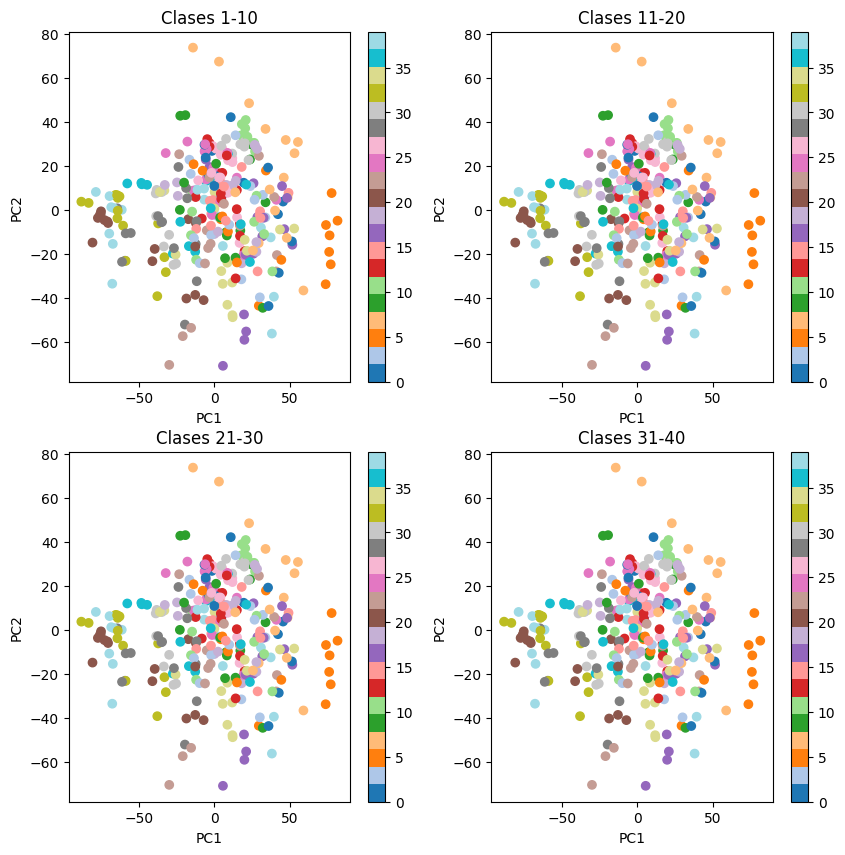

In [231]:
# Visualizar las dos primeras componentes principales
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_train)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i in range(4):
    ax = axes[i // 2, i % 2]
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='tab20')
    ax.set_title(f'Clases {i*10+1}-{(i+1)*10}')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    fig.colorbar(scatter, ax=ax)
plt.show()

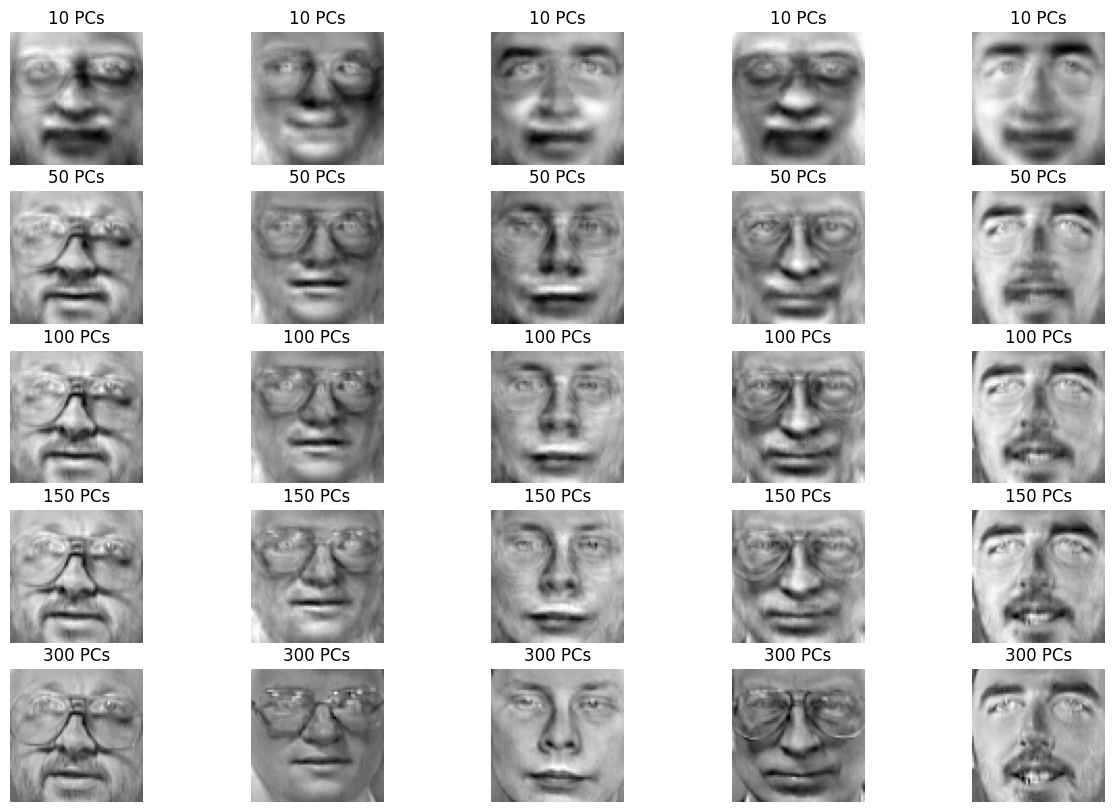

In [232]:

# Función para visualizar imágenes comprimidas y descomprimidas
def visualize_compressed_images(X_train, n_components_list):
    fig, axes = plt.subplots(len(n_components_list), 5, figsize=(15, 10))
    for i, n_components in enumerate(n_components_list):
        pca = PCA(n_components=n_components, random_state=42)
        X_train_pca = pca.fit_transform(X_train)
        X_train_unzipped = pca.inverse_transform(X_train_pca)
        for j in range(5):
            ax = axes[i, j]
            ax.imshow(X_train_unzipped[j].reshape(64, 64), cmap='gray')
            ax.set_title(f'{n_components} PCs')
            ax.axis('off')
    plt.show()

# Visualizar imágenes para diferentes números de componentes
n_components_list = [10, 50, 100, 150, 300]
visualize_compressed_images(X_train, n_components_list)